### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [5]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.datasets import VOCSegmentation

In [6]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=4):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 

    # Specify the path to the directory where you want to download the data
    data_dir = "/" #Downloads/"

    # Define the image transforms for both the input image AND the "label" image
    image_transforms = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    label_transforms = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        ToIntTensor()
    ])

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl


In [9]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """

    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    criterion = nn.CrossEntropyLoss(ignore_index=255)  # recommend to use in constructing loss

    # Initialize the train and validation losses
    train_loss = 0.0
    val_loss = 0.0
    accuracy = 0.0

    # Put the model in training mode
    model.train()
    total_samples=0
    # Iterate over the train dataloader
    for inputs, labels in train_dl:
        # Put the data on the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = outputs['out']
        labels = labels.squeeze(1) #.squeeze(0)  # Remove the extra dimensions

        loss = criterion(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the train loss
        train_loss += loss.item()

    # Put the model in evaluation mode
    model.eval()
    train_loss/=len(train_dl)
    # Iterate over the validation dataloader
    with torch.no_grad():
        for inputs, labels in val_dl:
            # Put the data on the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs['out']
            labels = labels.squeeze(1) #.squeeze(0)  # Remove the extra dimensions

            loss = criterion(outputs, labels)

            # Update the validation loss
            val_loss += loss.item()

            # Calculate the accuracy
            predicted_labels = outputs.argmax(dim=1)
            correct = (predicted_labels == labels).sum().item()
            accuracy += correct #/ len(labels)
            total_samples += labels.numel()
    accuracy/=total_samples
    accuracy*=100
    val_loss/=len(val_dl)
    # Return the train and validation loss and accuracy
    return train_loss, val_loss, accuracy


### Main loop

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64  # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50
learning_rate = 0.01
n_class = 21  # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model = fcn_resnet50(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

# Training loop
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
    
    # Print the loss, and store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy))

Using downloaded and verified file: /VOCtrainval_06-Nov-2007.tar
Extracting /VOCtrainval_06-Nov-2007.tar to /
Using downloaded and verified file: /VOCtrainval_06-Nov-2007.tar
Extracting /VOCtrainval_06-Nov-2007.tar to /
Epoch 1: Train loss: 2.330 | Val loss: 2.404 | Acc: 46.122
Epoch 2: Train loss: 1.019 | Val loss: 1.127 | Acc: 69.684
Epoch 3: Train loss: 0.895 | Val loss: 1.242 | Acc: 65.118
Epoch 4: Train loss: 0.665 | Val loss: 0.924 | Acc: 71.925
Epoch 5: Train loss: 0.587 | Val loss: 0.826 | Acc: 72.821
Epoch 6: Train loss: 0.432 | Val loss: 0.853 | Acc: 73.111
Epoch 7: Train loss: 0.384 | Val loss: 0.820 | Acc: 73.835
Epoch 8: Train loss: 0.356 | Val loss: 0.764 | Acc: 74.970
Epoch 9: Train loss: 0.314 | Val loss: 0.767 | Acc: 75.037
Epoch 10: Train loss: 0.292 | Val loss: 0.743 | Acc: 75.423
Epoch 11: Train loss: 0.281 | Val loss: 0.741 | Acc: 75.702
Epoch 12: Train loss: 0.272 | Val loss: 0.701 | Acc: 76.223
Epoch 13: Train loss: 0.278 | Val loss: 0.683 | Acc: 76.791
Epoch 14:

## Post training visualization and analysis

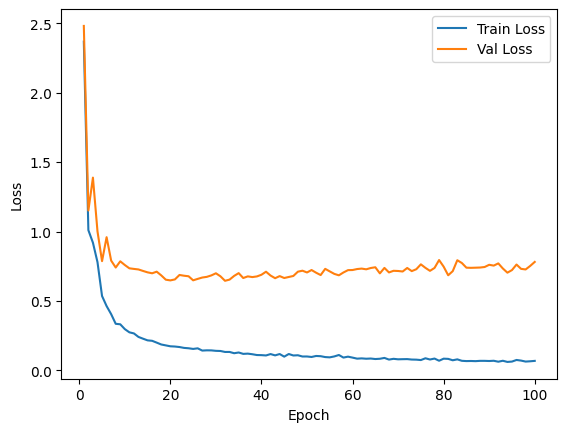

<ipython-input-21-d8e1a64e7358>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors


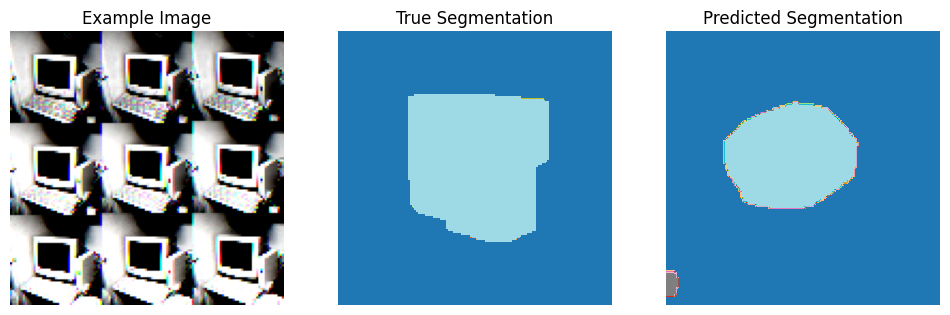

In [21]:
# TODO: Train and test loss plot
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors
# Plotting the losses
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
val_dataset = val_dl.dataset
# Get an example image, true segmentation, and predicted segmentation
example_idx = 0
example_image, example_label = val_dataset[example_idx]
example_image = example_image.to(device).unsqueeze(0)  # Add batch dimension and move to device
example_label = example_label.to(device).unsqueeze(0)  # Add batch dimension and move to device

# Forward pass through the model
model.eval()
with torch.no_grad():
    output = model(example_image)

# Get the predicted segmentation
_, predicted_label = torch.max(output['out'], 1)

# Convert tensors to numpy arrays
example_image = example_image.squeeze(0).cpu().numpy().reshape(128, 128, 3)
example_label = example_label.squeeze(0).cpu().numpy()
predicted_label = predicted_label.squeeze(0).cpu().numpy()

# Define the colormap
cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors

# Plot the example image, true segmentation, and predicted segmentation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(example_image)
axes[0].set_title('Example Image')
axes[0].axis('off')

example_label = np.array(example_label.reshape(128, 128)).astype(np.float32)

axes[1].imshow(example_label, cmap=cmap, vmin=0, vmax=1)
axes[1].set_title('True Segmentation')
axes[1].axis('off')
axes[2].imshow(predicted_label, cmap=cmap, vmin=0, vmax=n_class)
axes[2].set_title('Predicted Segmentation')
axes[2].axis('off')

plt.show()


In [12]:
# Feel free to use the outputs of my code for the confidence calibration plot and ECE
# Here I run the model on all points in the validation set. 
# I collect predictions on all pixels, excluding masks, and flatten them. 

model.eval()
with torch.no_grad():
    all_acc = []
    all_conf = []
    for i, (inputs, labels) in enumerate(val_dl):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)['out']
        labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
        predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
        probs = outputs.softmax(axis=1)  # batch, n_class, h, w
        confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
        accuracy = (predicted_label == labels)
        accuracy_filter = accuracy[labels < 255]
        confidence_filter = confidence[labels < 255]
        all_acc.append(accuracy_filter)
        all_conf.append(confidence_filter)
        
all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
        
# Get the average confidence and accuracy for points within different confidence ranges
bins = 10
bin_boundaries = np.linspace(0, 1, bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]
bin_centers = 0.5*(bin_lowers+bin_uppers)
bin_acc = np.zeros(bins)  # Store accuracy within each bin
bin_conf = np.zeros(bins)  # Store confidence within each bin
bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
for i in range(bins):
    in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
    bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
    if bin_frac[i] > 0.:
        bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
        bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
    else:
        bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway

Expected Calibration Error (ECE): 0.072


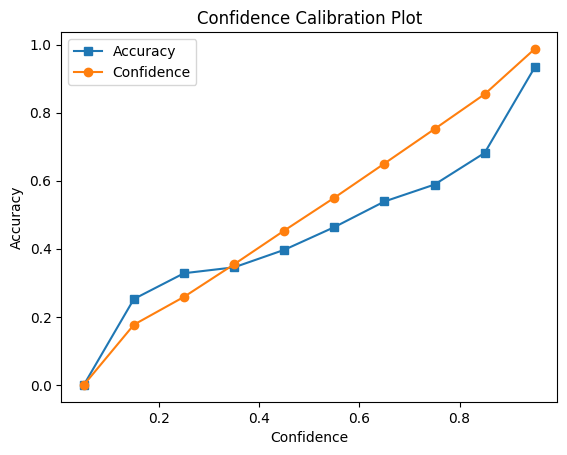

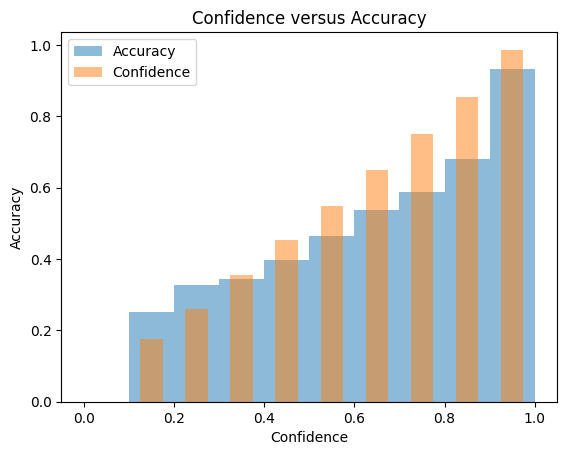

In [15]:
# TODO: Plot confidence calibration curve and calculate expected calibration error (1 point), using 
ece = np.sum(bin_frac * np.abs(bin_acc - bin_conf))
print('Expected Calibration Error (ECE): %.3f' % ece)
# Confidence calibration plot
plt.plot(bin_centers, bin_acc, 's-', label='Accuracy')
plt.plot(bin_centers, bin_conf, 'o-', label='Confidence')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence Calibration Plot')
plt.legend()
plt.show()

# Expected Calibration Error (ECE)


# Confidence versus accuracy bar chart
plt.bar(bin_centers, bin_acc, width=0.1, align='center', alpha=0.5, label='Accuracy')
plt.bar(bin_centers, bin_conf, width=0.05, align='center', alpha=0.5, label='Confidence')
plt.xlabel('Confidence')
plt.ylabel('Accuracy')
plt.title('Confidence versus Accuracy')
plt.legend()
plt.show()


# TODO: confidence versus accuracy bar chart